In [135]:
from src.data_functions import wrangle
w = wrangle()
pat = pd.read_csv('data/patient_cleaned.csv', infer_datetime_format=True)
appt = pd.read_csv('data/appt_cleaned.csv', infer_datetime_format=True, low_memory=False)
pay = pd.read_csv('data/payment.csv',  low_memory=False)

#### Drop uneeded patient columns

In [136]:
pat = pat.iloc[:, :-1]
pat.drop(['Address', 'Address2', 'ImageFolder', 'ChartNumber', 'Premed'], axis=1, inplace=True)

In [137]:
pat['fullname'] = pat['FName'] + ' ' + pat['LName']
pat['fullname'] = pat['fullname'].str.lower()
pat = w.patient_dropper(pat, 'PatNum', [2661, 5557, 2])
pat = w.patient_dropper(pat, 'LName', ['.'])
pat = w.patient_dropper(pat, 'fullname', ['becky weigel', 'kelsey visco'])

#### Filled 16 DateFirstVisit bad entries with AptDateTime

In [138]:
bad_entries = pat[pat['DateFirstVisit'] == '0001-01-01'].PatNum.tolist()
fixed_records = appt[appt['PatNum'].isin(bad_entries)][['PatNum', 'AptDateTime']]
fixed_records['AptDateTime'] = pd.to_datetime(fixed_records['AptDateTime']).dt.date
fixed_records = fixed_records.sort_values('PatNum')
inds = pat[pat['PatNum'].isin(fixed_records['PatNum'])].sort_values('PatNum').index

In [139]:
for index, date in zip(inds, fixed_records['AptDateTime']):
    pat.loc[index, 'DateFirstVisit'] = date

In [140]:
#Duplicated patients code
#pat[pat.loc[:, ['Birthdate', 'fullname']].duplicated(keep=False)].sort_values('fullname').head(100)

In [141]:
w.downcast(pat)
w.downcast(appt)

### Build Recency Table for Kmeans

In [142]:
recency = appt.merge(pat)
w.todate(recency, ['Birthdate', 'AptDateTime', 'DateFirstVisit', ])
recency['AptDateTime'] = recency.AptDateTime.dt.date
recency['AptDateTime'] = pd.to_datetime(recency['AptDateTime'])

In [143]:
pat.to_csv('data/patient_int.csv', index=False)

In [144]:
from datetime import datetime
now = pd.to_datetime(datetime.now())
now = pd.to_datetime(now.date())
maxdates = recency.groupby('PatNum')['AptDateTime'].max()
maxdates = maxdates.to_frame().reset_index()
maxdates['recency'] = (now - maxdates['AptDateTime']).dt.days

In [146]:
maxdates.to_csv('data/recency.csv', index=False)

### Recency Distribution

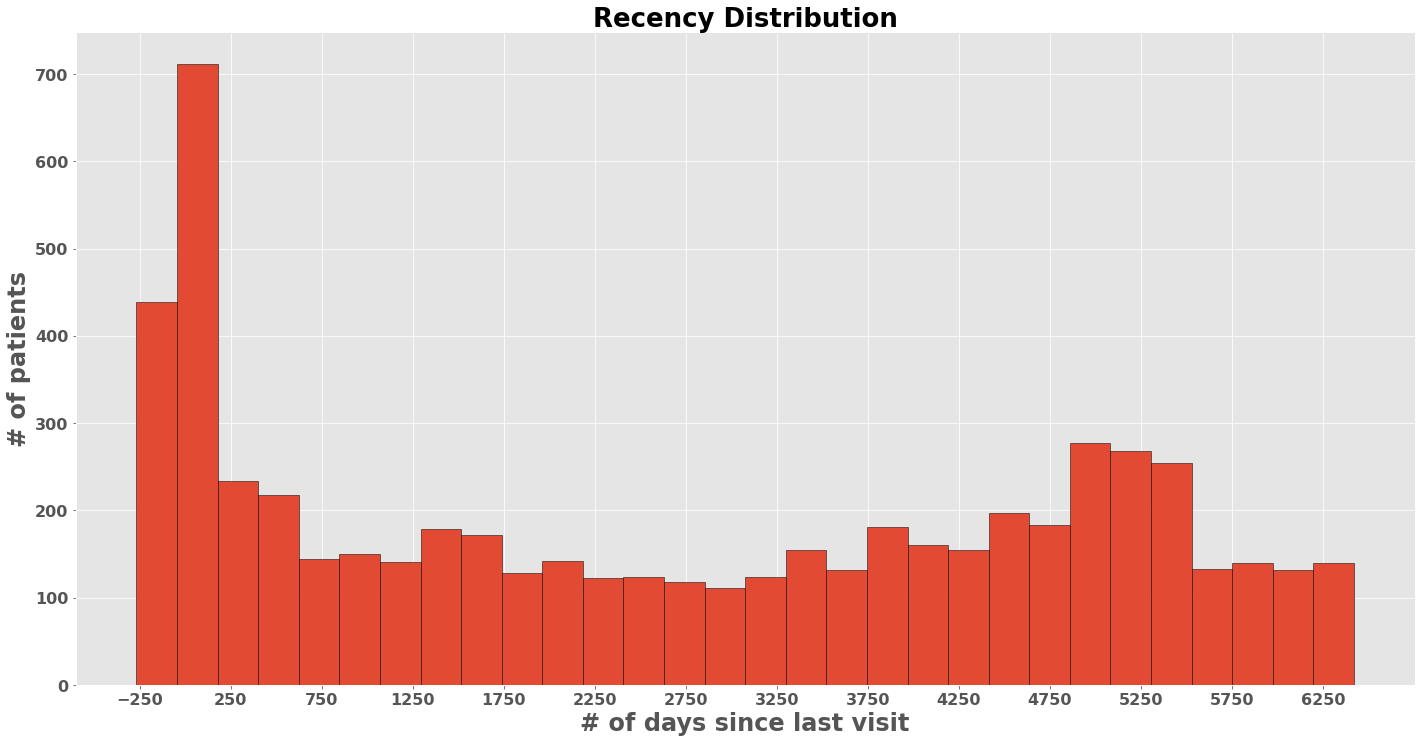

In [118]:
fig = plt.figure(figsize=(24, 12))
plot = maxdates['recency'].hist(bins=30, edgecolor='black')
title = plt.title('Recency Distribution', fontweight='bold', fontsize=26)
xticks = plt.xticks(np.arange(-250, 6750, 500), fontweight='bold', fontsize=16)
yticks = plt.yticks(fontweight='bold', fontsize=16)
xlabel = plt.xlabel('# of days since last visit', fontweight='bold', fontsize = 24)
ylabel = plt.ylabel('# of patients',  fontweight='bold', fontsize = 24)

In [51]:
pay_table = pay.groupby('PatNum')['PayAmt'].agg({'sum', 'mean'}).reset_index()
pay_table.rename(columns={'sum':'total_value', 'mean':'mean_value'}, inplace=True)

In [52]:
pay_table.sort_values(['total_value', 'mean_value'], ascending=False).head()

,PatNum,total_value,mean_value
3191,5361,27413.00,472.637931
893,1516,25470.00,363.857143
32,38,21465.63,210.447353
673,1134,21445.84,172.950323
1900,3168,21439.90,389.816364


In [53]:
test2 = test.merge(pay_table).drop('mean_value', axis=1)

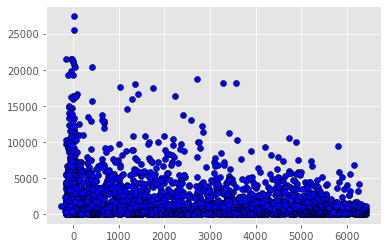

In [54]:
X = test2.recency
y = test2.total_value
plt.scatter(X, y, edgecolor='black', c='blue')

In [55]:
len(set(test.PatNum).intersection(set(pay_table.PatNum)))

4005

In [56]:
user.drop("AptDateTime", axis=1, inplace=True)

In [57]:
test = user.merge(pay_table)
test.drop(['RecencyCluster', 'PatNum'], axis=1, inplace=True)
test

,recency,total_value,mean_value
0,1220,0.00,0.000000
1,-97,10216.24,138.057297
2,-83,4301.22,113.190000
3,-154,21465.63,210.447353
4,-103,4914.90,65.532000
...,...,...,...
4000,1722,1670.00,556.666667
4001,1770,230.00,115.000000
4002,1708,0.00,0.000000
4003,1707,1897.97,135.569286


In [68]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(test[['recency']])
test['RecencyCluster'] = kmeans.predict(test[['recency']])

KMeans(n_clusters=4)

In [73]:
test.groupby("RecencyCluster")['recency'].describe().sort_values('mean')

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
3,1446.0,165.643154,295.412814,-267.0,-49.00,8.0,352.00,946.0
0,860.0,1743.405814,482.433113,952.0,1336.75,1693.0,2149.00,2675.0
1,830.0,3623.080723,518.833434,2680.0,3204.00,3637.0,4046.75,4516.0
2,869.0,5407.841197,501.779529,4517.0,5021.00,5357.0,5797.00,6420.0


In [75]:
target_group = test.query('RecencyCluster == 3')

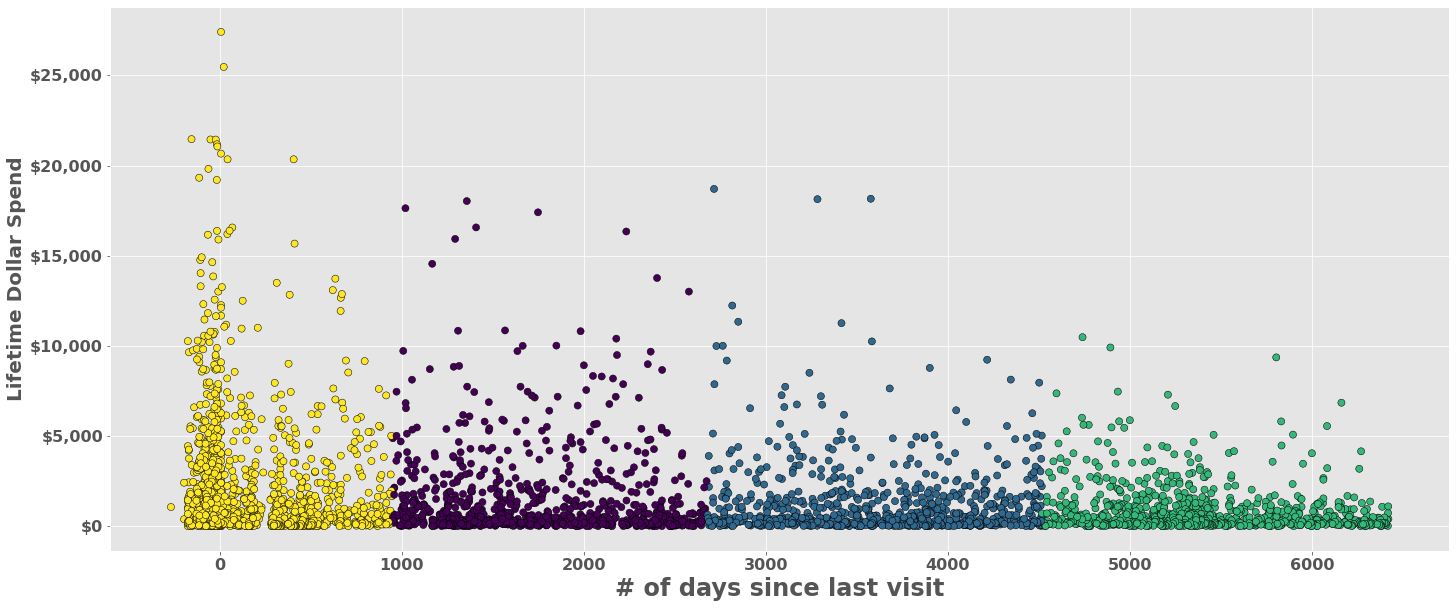

In [70]:
X = test.recency
y = test.total_value
colors = test.RecencyCluster
fig, ax = plt.subplots(1, 1, figsize=(24, 10))
plt.scatter(X, y, c=colors, s=50, cmap='viridis', edgecolor='black')
fmt = '${x:,.0f}'
tick = ticker.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 
xticks = plt.xticks(fontweight='bold', fontsize=16)
yticks = plt.yticks(fontweight='bold', fontsize=16)
xlabel = plt.xlabel('# of days since last visit', fontweight='bold', fontsize = 24)
ylabel = plt.ylabel('Lifetime Dollar Spend',  fontweight='bold', fontsize = 20)

/Users/americanthinker/anaconda/envs/snakes/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/americanthinker/anaconda/envs/snakes/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/americanthinker/anaconda/envs/snakes/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

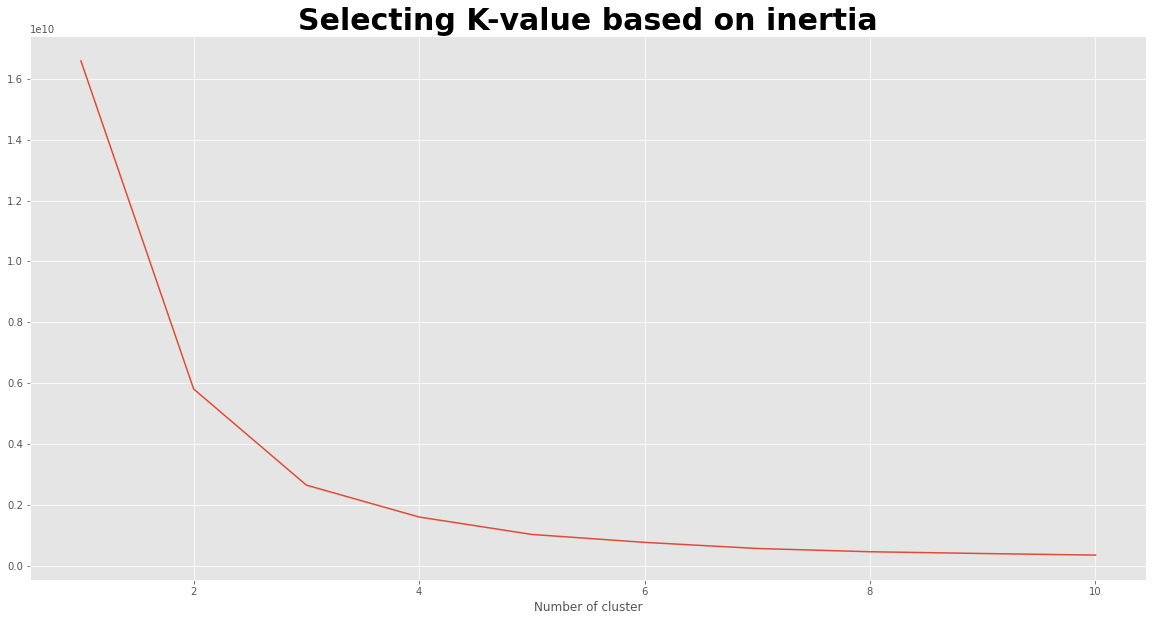

In [77]:
sse={}
krecency = target_group[['recency', 'total_value']]
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(krecency)
    krecency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
fig = plt.figure(figsize=(20,10))
plot = plt.plot(list(sse.keys()), list(sse.values()))
xlabel = plt.xlabel("Number of cluster")
title = plt.title('Selecting K-value based on inertia', fontsize=30, fontweight='bold')

In [98]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(target_group[['total_value']])
target_group['RecencyCluster'] = kmeans.predict(target_group[['total_value']])

KMeans(n_clusters=3)

/Users/americanthinker/anaconda/envs/snakes/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [99]:
target_group

,recency,total_value,mean_value,RecencyCluster
1,-97,10216.24,138.057297,1
2,-83,4301.22,113.190000,2
3,-154,21465.63,210.447353,1
4,-103,4914.90,65.532000,2
5,-34,4829.30,137.980000,2
...,...,...,...,...
1879,-152,43.00,21.500000,0
1880,-12,300.00,150.000000,0
1881,-33,593.50,296.750000,0
1882,-167,280.00,140.000000,0


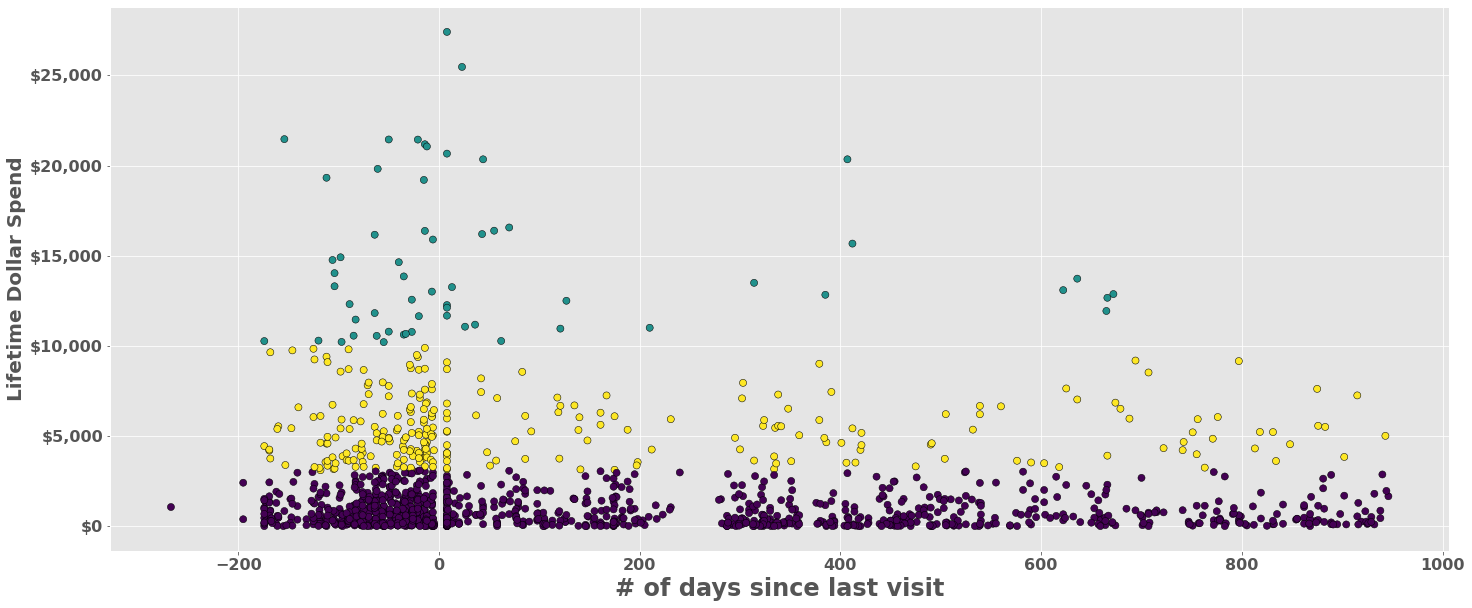

In [137]:
X = target_group.recency
y = target_group.total_value
colors = target_group.RecencyCluster
fig, ax = plt.subplots(1, 1, figsize=(24, 10))
plot = plt.scatter(X, y, c=colors, s=50, cmap='viridis', edgecolor='black')
fmt = '${x:,.0f}'
tick = ticker.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 
xticks = plt.xticks(fontweight='bold', fontsize=16)
yticks = plt.yticks(fontweight='bold', fontsize=16)
xlabel = plt.xlabel('# of days since last visit', fontweight='bold', fontsize = 24)
ylabel = plt.ylabel('Lifetime Dollar Spend',  fontweight='bold', fontsize = 20)

In [142]:
order_cluster('RecencyCluster', 'recency', target_group, False).groupby("RecencyCluster")['recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,1124.0,178.668149,298.833510,-267.0,-47.0,14.5,386.0,946.0
1,263.0,133.406844,289.379037,-174.0,-56.0,-12.0,318.5,943.0
2,59.0,61.203390,218.548723,-174.0,-61.5,-14.0,49.5,672.0


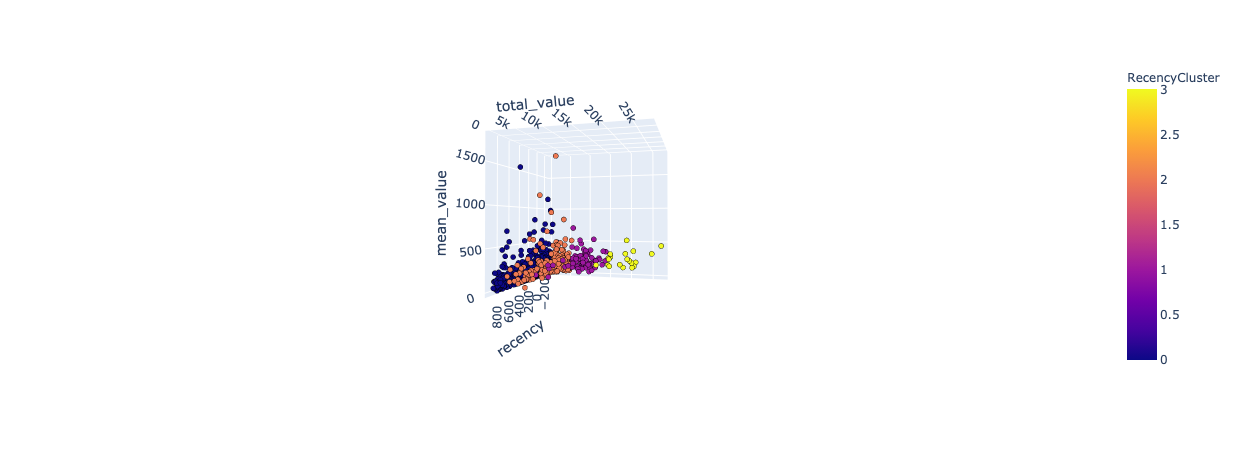

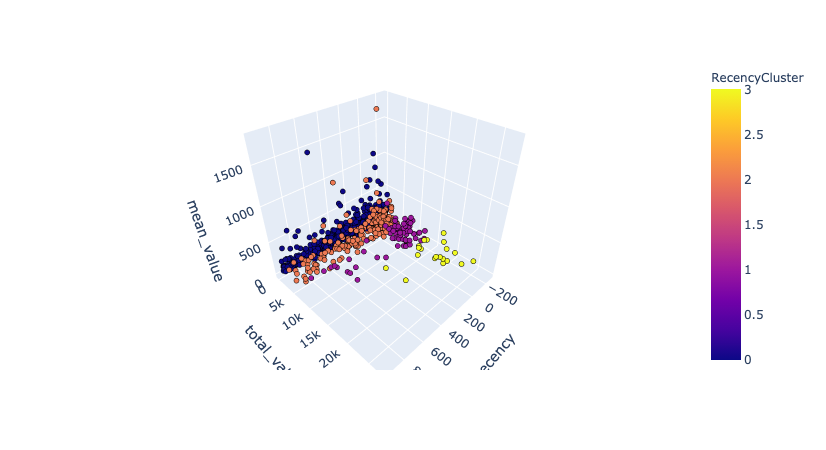

In [87]:
import plotly.express as px
fig = px.scatter_3d(target_group, x='recency', y='total_value', z='mean_value',
              color='RecencyCluster')
fig.update_traces(marker=dict(size=3,
                              line=dict(width=2,
                                        color='black')),
                  selector=dict(mode='markers'))
fig.show()

In [113]:
pt = pd.read_csv('/Users/americanthinker/Downloads/appt_cleaned.csv', infer_datetime_format=True)

/Users/americanthinker/anaconda/envs/snakes/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning:

Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.



In [114]:
pt.head()

,AptNum,PatNum,AptStatus,Confirmed,Op,Note,ProvNum,AptDateTime,InsPlan1,InsPlan2,ProcsColored
0,51336,5676,2,21,1,pro/exam\r\n,6,2016-07-14 13:00:00,1143,0,NaN
1,51337,5676,2,21,2,loose filling UL #13\r\n--------------- Mon - ...,1,2016-07-19 10:00:00,1143,0,NaN
2,51338,1563,2,21,1,"pro/exam\r\n--------------- Mon - Jan 9, 2017 ...",2,2017-01-17 14:00:00,572,0,NaN
3,51339,5326,2,361,1,"pro/exam only\r\n--------------- Mon - Jan 9, ...",2,2017-01-18 14:00:00,2268,0,NaN
4,51340,5167,2,21,1,"Pro\r\n--------------- Mon - Jan 9, 2017 -----...",6,2017-05-04 15:00:00,1389,0,NaN


In [116]:
notes = pt.Note

In [129]:
clean_notes = notes.str.strip().str.replace('\n', '').str.replace('\r', '').str.lower()

In [136]:
clean_notes[clean_notes.str.contains('prophy')].str.replace(',','').str.replace('/', ' ').value_counts().head(50)

prophy                           1222
exam 4bw prophy                   248
prophyad                          239
exam prophy                       125
prophy fmp                         96
prophy exam                        81
4bw prophy                         78
exam 4bw pa1st pa prophy           63
prophy flo                         51
exam fmx prophy                    38
prophy flv                         25
exam prophy fmp                    25
exam 4bw pa prophy pa              19
prophych                           19
4bw pa1st pa prophy                17
fmx prophy                         17
exam 4bw prophy flo                16
exam 4bw pa1st prophy              14
exam 4bw pa prophy                 12
4bw prophy flo                     10
prophy adult                       10
fmx prophy np exam                  9
prophy flo fmp                      9
prophyad exam 4 bws                 8
exam prophy flo                     7
prophy bwx exam                     7
prophyad exa